In [98]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"          # shows multiple outputs

import warnings
warnings.filterwarnings('ignore')

In [109]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

# Get Processed Data

In [1]:
!ls

LICENSE                   data_docs                 nces_analysis.ipynb
README.md                 data_features-Copy1.ipynb processed
data                      data_features.ipynb


In [2]:
!ls processed

hsls_16_student_processed.csv


In [5]:
data_path='processed/hsls_16_student_processed.csv'
df = pd.read_csv(data_path)

In [7]:
cols_list = df.columns

# Feature Engineering

### students' assessment of math/science teachers

In [8]:
# students' assessment of math teachers

rex = re.compile('S1MTCH')
math_teach = [col for col in cols_list if re.match(rex, col)]

# students' assessment of science teachers

rex = re.compile('S1STCH')
sci_teach = [col for col in cols_list if re.match(rex, col)]

# from the documentation (Codebook.txt)
# features in math_teach, sci_teach take values

# Category            Label                                            
# ------------------- -----------------------
# 1                   Strongly agree                  
# 2                   Agree                         
# 3                   Disagree                   
# 4                   Strongly disagree        
# -9                  Missing                  
# -8                  Unit non-response         
# -7                  Item legitimate skip/NA                                                                   

In [9]:
# create features from math/science teacher assessment variables

math_teach_new = list()
for col in math_teach:
    df[col+'_agree']    = df[col].isin([1,2])
    df[col+'_disagree'] = df[col].isin([3,4])
    math_teach_new += [col+'_agree',col+'_disagree']
    
sci_teach_new = list()    
for col in sci_teach:
    df[col+'_agree']    = df[col].isin([1,2]) 
    df[col+'_disagree'] = df[col].isin([3,4]) 
    sci_teach_new += [col+'_agree',col+'_disagree']

### students' self assessment of math/science ability

In [10]:
# variables describing students' self assessment of math ability

ind_self_beg = df.columns.get_loc('S1MPERSON1')
ind_self_end = df.columns.get_loc('S1MASSEXCL')

math_self = df.columns[ind_self_beg:ind_self_end+1].to_list()

# variables describing students' self assessment of science ability

ind_self_beg = df.columns.get_loc('S1SPERSON1')
ind_self_end = df.columns.get_loc('S1SASSEXCL')

sci_self = df.columns[ind_self_beg:ind_self_end+1].to_list()

### student took AP math/science

In [12]:
# variables describing whether students took AP math/science

AP_ms = ['S3APMATH','S3APSCIENCE']

In [13]:
# create outcome variables representing whether a student 
# took AP math or science: yes, no, missing

def ynm(x):
    if x in [1]: # yes
        return 1
    if x in [0,-7]: # no
        return 0
    else:        # x in [-9,-8,-4] - missing
        return -1

In [14]:
for col in ['S3APMATH','S3APSCIENCE']:
    df[col+'_ynm'] = df[col].apply(ynm) 

### student race

In [29]:
# variables describing race

race = ['X1RACE']

# Category            Label                                     
# ------------ ------------------------------------------------
# 1             Amer. Indian/Alaska Native, non-Hispanic  
# 2             Asian, non-Hispanic                      
# 3             Black/African-American, non-Hispanic     
# 4             Hispanic, no race specified          
# 5             Hispanic, race specified                   
# 6             More than one race, non-Hispanic         
# 7             Native Hawaiian/Pacific Islander, non-Hispanic
# 8             White, non-Hispanic     
# -9            Missing  

In [30]:
# may drop missing data during analysis

### student IEP

In [31]:
# variables describing IEP

iep = ['X1IEPFLAG']


# Category            Label              
# ------------------- -------------------
# 0                   Student has no IEP  
# 1                   Student has an IEP      
# -9                  Missing  

In [32]:
# may drop missing during analysis

### graduated/GED/dropout

In [33]:
# variables describing graduation/GED/dropout

grad = ['X3HSCOMPSTAT']

# from the documentation (Codebook.txt)
# X3HSCOMPSTAT takes values

# Category            Label                               
# -------- ----------------------------------------- 
# 1         High school diploma                      
# 2         GED, cert of attendance, or other HS equiv
# 3         Dropped out       
# 4         Still enrolled    
# 5         Status unknown    

In [34]:
# create feature to indicate if student graduated of received GED

df['grad_GED'] = df['X3HSCOMPSTAT'].isin([1,2])

### parents' education

In [35]:
# variables describing parents education

pared = ['X1PAR1EDU','X1PAR2EDU']

# Category            Label                               
# ------------------- -----------------------------------------
# 1                   Less than high school       
# 2                   High school diploma or GED        
# 3                   Associate's degree                     
# 4                   Bachelor's degree                      
# 5                   Master's degree                          
# 7                   Ph.D/M.D/Law/other high lvl prof degree  
# -9                  Missing                                
# -8                  Unit non-response 
# -7                  Item legitimate skip/NA 

In [36]:
# may drop missing responses during analysis

# Data Analysis

### race and graduation rate

In [89]:
# drop data where grad/GED/drop is unknown

df_grad_race = df[df['X3HSCOMPSTAT'].isin([1,2,3])][['X1RACE','grad_GED']]

In [90]:
df_grad_race.head()

,X1RACE,grad_GED
0,8,True
1,8,True
2,3,True
3,8,True
4,8,True


In [91]:
df_grad_race['grad_GED'].value_counts(normalize=True).reset_index()

,index,grad_GED
0,True,0.963588
1,False,0.036412


In [92]:
# change numerical race data to descriptive

def race_map(x):
    d={1:'Amer. Indian/Alaska Native',
       2:'Asian',
       3:'Black/African-American',     
       4:'Hispanic, no race specified',          
       5:'Hispanic, race specified',                   
       6:'More than one race',         
       7:'Native Hawaiian/Pacific Islander',
       8:'White',     
      -9:'Missing'}
    y = d[x]
    return y

In [93]:
df_grad_race['Race'] = df_grad_race['X1RACE'].apply(race_map)
df_grad_race = df_grad_race.drop('X1RACE', axis=1)

In [101]:
# calculate proportion of each race grad/GED

df_gr = df_grad_race.groupby('Race')['grad_GED'].value_counts(normalize=True)
df_gr

Race                              grad_GED
Amer. Indian/Alaska Native        True        0.862595
                                  False       0.137405
Asian                             True        0.988610
                                  False       0.011390
Black/African-American            True        0.952473
                                  False       0.047527
Hispanic, no race specified       True        0.906250
                                  False       0.093750
Hispanic, race specified          True        0.956676
                                  False       0.043324
Missing                           True        0.960089
                                  False       0.039911
More than one race                True        0.960214
                                  False       0.039786
Native Hawaiian/Pacific Islander  True        0.952381
                                  False       0.047619
White                             True        0.967231
                      

In [ ]:
# change the decimals to percents

df_gr = df_gr[:,True]*100

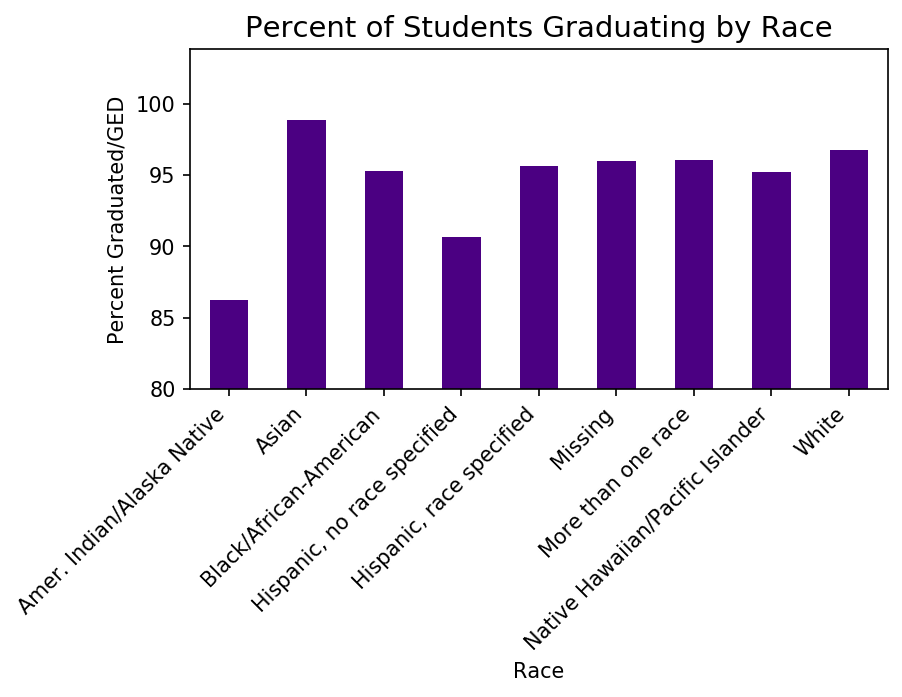

In [110]:
# plot percent of each race grad/GED

ax = df_gr.plot(kind='bar', figsize=(6,3), color="indigo", fontsize=10)
ax.set_alpha(0.8)
ax.set_title("Percent of Students Graduating by Race", fontsize=14)
ax.set_ylabel("Percent Graduated/GED", fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
bottom, top = plt.ylim()
plt.ylim(bottom=80)
plt.show();

### parent education and graduation rate

In [115]:
# drop data where grad/GED/drop is unknown

df_grad_pared = df[df['X3HSCOMPSTAT'].isin([1,2,3])][pared+['grad_GED']]
df_grad_pared.head()
df_grad_pared.shape

,X1PAR1EDU,X1PAR2EDU,grad_GED
0,5,5,True
1,3,2,True
2,7,-7,True
3,4,-7,True
4,4,-7,True


(20680, 3)

In [118]:
# focus on parent 1's education and drop unkown education level data

df_grad_pared = df_grad_pared[df_grad_pared['X1PAR1EDU']>0][['X1PAR1EDU','grad_GED']]
df_grad_pared.shape

(15340, 2)

In [121]:
# change numerical education data to descriptive

def edu(x):
    d={1:'Less than high school',
       2:'High school diploma or GED',
       3:'Associate\'s degree',
       4:'Bachelor\'s degree',
       5:'Master\'s degree',
       7:'Ph.D/M.D/Law/other high lvl prof degree'}
    y = d[x]
    return y

In [122]:
df_grad_pared['Parent\'s Education'] = df_grad_pared['X1PAR1EDU'].apply(edu)
df_grad_pared = df_grad_pared.drop('X1PAR1EDU',axis=1)

In [123]:
df_grad_pared.head()

,grad_GED,Parent's Education
0,True,Master's degree
1,True,Associate's degree
2,True,Ph.D/M.D/Law/other high lvl prof degree
3,True,Bachelor's degree
4,True,Bachelor's degree


In [124]:
# proportion of each parent education category graduating/getting GED

df_gpe = df_grad_pared.groupby('Parent\'s Education')['grad_GED'].value_counts(normalize=True)
df_gpe

Parent's Education                       grad_GED
Associate's degree                       True        0.979325
                                         False       0.020675
Bachelor's degree                        True        0.991890
                                         False       0.008110
High school diploma or GED               True        0.958134
                                         False       0.041866
Less than high school                    True        0.908503
                                         False       0.091497
Master's degree                          True        0.994895
                                         False       0.005105
Ph.D/M.D/Law/other high lvl prof degree  True        0.992793
                                         False       0.007207
Name: grad_GED, dtype: float64

In [125]:
df_gpe = df_gpe[:,True]*100

In [131]:
sortd_in = ['Less than high school','High school diploma or GED',
           'Associate\'s degree','Bachelor\'s degree',
           'Master\'s degree','Ph.D/M.D/Law/other high lvl prof degree']

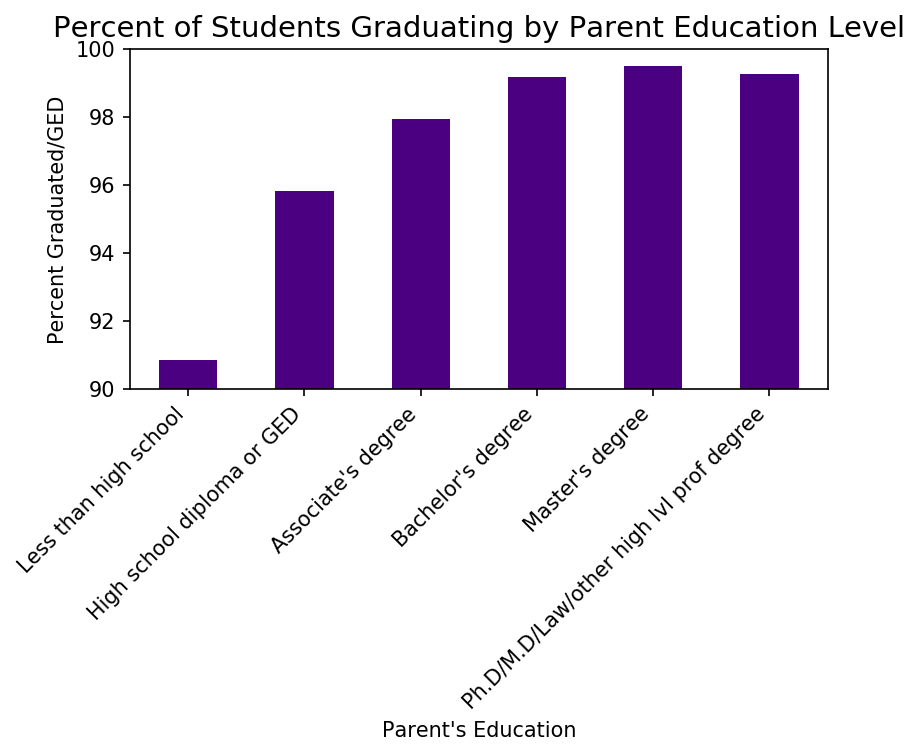

In [132]:
# plot percent of each parent edu level graduating/GED

ax = df_gpe[sortd_in].plot(kind='bar', figsize=(6,3), color="indigo", fontsize=10)
ax.set_alpha(0.8)
ax.set_title("Percent of Students Graduating by Parent Education Level", fontsize=14)
ax.set_ylabel("Percent Graduated/GED", fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
bottom, top = plt.ylim()
plt.ylim(bottom=90, top=100)
plt.show();

# Save Data with Engineered Features

In [133]:
out_path = './processed/hsls_16_student_engineered.csv'
df.to_csv(out_path)